# Toxic Comment Classification Challenge
# Base Model Training

## Introduction

In this notebook, we will train a baseline model to establish a reference point for model performance on the toxic comment classification task. The baseline will help us evaluate the effectiveness of future improvements.

### Environment and Data Setup

In [5]:
import os
import sys

import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import torch
from transformers import DistilBertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
import pytorch_lightning as pl


sys.path.append('../')
from utils import compare_datasets, compute_class_weights, compute_toxic_nontoxic_weights
from utils import MultiLabelDataset
from utils import Base_Model
from utils import Base_pl_Model
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda:0


In [2]:
train_data = pd.read_csv('../data/augmented_data.csv')
print(train_data.head())

                 id  toxic  severe_toxic  obscene  threat  insult  \
0  0000997932d777bf      0             0        0       0       0   
1  000103f0d9cfb60f      0             0        0       0       0   
2  000113f07ec002fd      0             0        0       0       0   
3  0001b41b1c6bb37e      0             0        0       0       0   
4  0001d958c54c6e35      0             0        0       0       0   

   identity_hate                                       cleaned_text  
0              0  explanation why the edits made under my userna...  
1              0  daww he match this background colour i am seem...  
2              0  hey man i am really not trying to edit war it ...  
3              0  more i cannot make any real suggestion on impr...  
4              0  you sir are my hero any chance you remember wh...  


In [3]:
train_data.drop(['id'], inplace=True, axis=1)

In [4]:
print(train_data.head())

   toxic  severe_toxic  obscene  threat  insult  identity_hate  \
0      0             0        0       0       0              0   
1      0             0        0       0       0              0   
2      0             0        0       0       0              0   
3      0             0        0       0       0              0   
4      0             0        0       0       0              0   

                                        cleaned_text  
0  explanation why the edits made under my userna...  
1  daww he match this background colour i am seem...  
2  hey man i am really not trying to edit war it ...  
3  more i cannot make any real suggestion on impr...  
4  you sir are my hero any chance you remember wh...  


In [5]:
train_data['is_toxic'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=123)

for train_idx, temp_idx in strat_split.split(train_data, train_data['is_toxic']):
    train_df = train_data.iloc[train_idx]
    temp_df = train_data.iloc[temp_idx]

val_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=123)

for val_idx, test_idx in val_test_split.split(temp_df, temp_df['is_toxic']):
    val_df = temp_df.iloc[val_idx]
    test_df = temp_df.iloc[test_idx]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Original Dataset: {train_data.shape}")
print(f"Training Dataset: {train_df.shape}")
print(f"Validation Dataset: {val_df.shape}")
print(f"Test Dataset: {test_df.shape}")

Original Dataset: (161629, 8)
Training Dataset: (113140, 8)
Validation Dataset: (24244, 8)
Test Dataset: (24245, 8)


#### Data Distributions in Dataframes

In [7]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
compare_datasets(train_df, val_df, test_df, label_columns)


--- Binary Toxic vs. Non-Toxic Distribution ---

Training Set:
is_toxic
0    87.811561
1    12.188439
Name: proportion, dtype: float64

Validation Set:
is_toxic
0    87.811417
1    12.188583
Name: proportion, dtype: float64

Test Set:
is_toxic
0    87.81192
1    12.18808
Name: proportion, dtype: float64

--- Distribution of Each Toxic Class ---

Training Set:
toxic            11.525544
severe_toxic      2.048789
obscene           6.934771
threat            1.077426
insult            6.550292
identity_hate     1.804844
dtype: float64

Validation Set:
toxic            11.495628
severe_toxic      2.025243
obscene           6.941924
threat            1.002310
insult            6.743937
identity_hate     1.831381
dtype: float64

Test Set:
toxic            11.420912
severe_toxic      1.988039
obscene           6.850897
threat            1.142504
insult            6.475562
identity_hate     1.810683
dtype: float64


#### Class Weights of Train Data

In [8]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_weights_tensor = compute_class_weights(train_df, label_columns)
toxic_weights_tensor = compute_toxic_nontoxic_weights(train_df, 'is_toxic')

Class Weights: tensor([0.0369, 0.2074, 0.0613, 0.3943, 0.0649, 0.2354])
Class Weights: tensor([0.1219, 0.8781])


In [9]:
train_data = train_data.drop(columns=['is_toxic'])

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

max_len = 128
text_column = 'cleaned_text'

train_dataset = MultiLabelDataset(train_df, tokenizer, max_len, label_columns, text_column)
val_dataset = MultiLabelDataset(val_df, tokenizer, max_len, label_columns, text_column)
test_dataset = MultiLabelDataset(test_df, tokenizer, max_len, label_columns, text_column)

In [11]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset), num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset), num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset), num_workers=4, persistent_workers=True)

#### Model Init and Learning Rate Finder

In [12]:
model = Base_Model(freeze_base=True).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=1e-9)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\MiestoMeska\anaconda3\envs\TC_4\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at C:\Users\MiestoMeska\Desktop\Mokslai\TC\Module4\Sprint_2\Project\vruzga-DL.2.5\notebooks\.lr_find_11992d02-9703-44d4-9ee6-551320710a99.ckpt
Restored all states from the checkpoint at C:\Users\MiestoMeska\Desktop\Mokslai\TC\Module4\Sprint_2\Project\vruzga-DL.2.5\notebooks\.lr_find_11992d02-9703-44d4-9ee6-551320710a99.ckpt


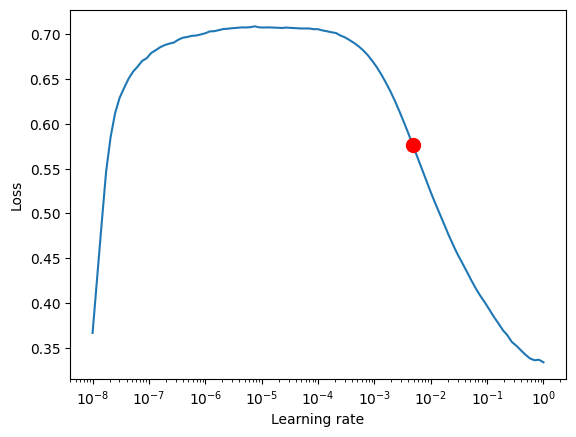

Suggested Learning Rate: 0.00478630092322638


In [13]:
my_model = Base_pl_Model(
    model=model,
    num_labels=6,
    learning_rate=1e-8,
    model_name="baseline_freeze",
    class_weights=class_weights_tensor,
)
torch.set_float32_matmul_precision('high')

trainer = pl.Trainer(
    max_epochs=5,
    enable_checkpointing=False,
    enable_progress_bar=False,
    logger=False
)

tuner = pl.tuner.Tuner(trainer)

lr_finder = tuner.lr_find(my_model, train_loader, val_loader)

fig = lr_finder.plot(suggest=True)
plt.show()

suggested_lr = lr_finder.suggestion()
print(f"Suggested Learning Rate: {suggested_lr}")

my_model.learning_rate = suggested_lr

#### Model Training

In [14]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_macro_f1',
    dirpath='../models/baseline_model/', 
    filename='base_model_freezed', 
    save_top_k=1,  
    mode='max',
    save_last=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_macro_f1',
    patience=6,
    mode='max'
)

trainer = pl.Trainer(
    max_epochs=99,
    callbacks=[early_stopping_callback, checkpoint_callback], 
    check_val_every_n_epoch=1,
    logger=True
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\MiestoMeska\anaconda3\envs\TC_4\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


C:\Users\MiestoMeska\anaconda3\envs\TC_4\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\MiestoMeska\Desktop\Mokslai\TC\Module4\Sprint_2\Project\vruzga-DL.2.5\models\baseline_model exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | Base_Model         | 66.4 M | train
1 | train_macro_f1 | MultilabelF1Score  | 0      | train
2 | val_macro_f1   | MultilabelF1Score  | 0      | train
3 | test_macro_f1  | MultilabelF1Score  | 0      | train
4 | loss_fn        | BCEWithLogitsLoss  | 0      | train
5 | train_accuracy | MultilabelAccuracy | 0      | train
6 | val_accuracy   | MultilabelAccuracy | 0      | train
7 | test_accuracy  | MultilabelAccuracy | 0      | train
8 | val_auroc      | MultilabelAUROC    | 0      | train
9 | test_auroc     | MultilabelAUROC    | 0      | train
--------

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

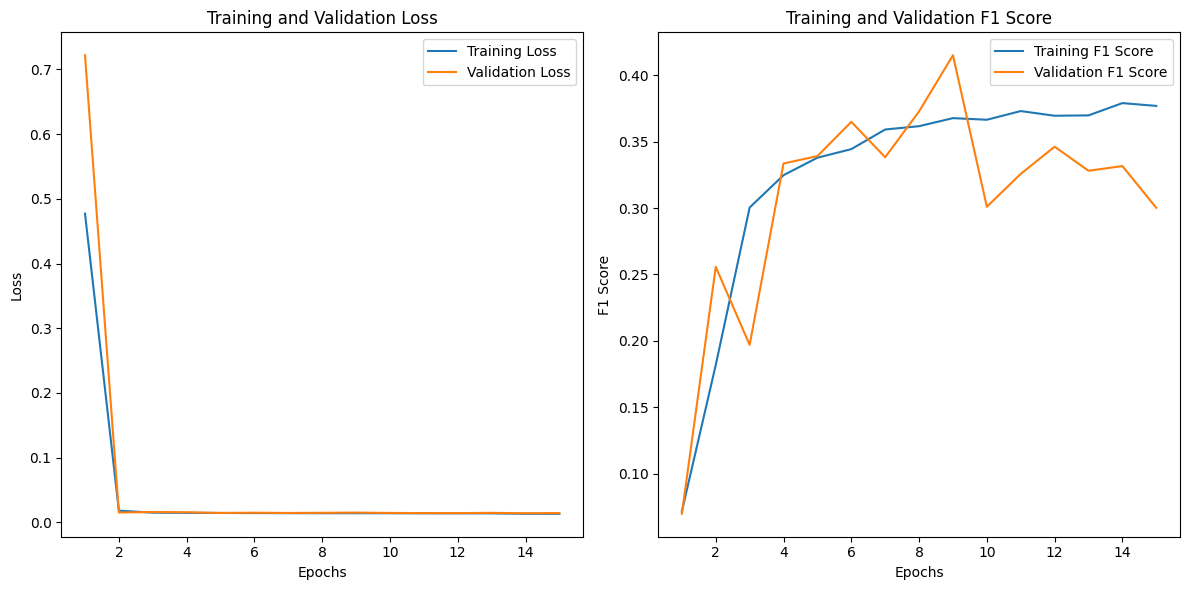

In [15]:
trainer.fit(my_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

### Trained Model Performance

In [26]:
print("Best model saved at:", checkpoint_callback.best_model_path)
print("Best val_macro_f1 score:", checkpoint_callback.best_model_score)

Best model saved at: C:\Users\MiestoMeska\Desktop\Mokslai\TC\Module4\Sprint_2\Project\vruzga-DL.2.5\models\baseline_model\base_model_freezed.ckpt
Best val_macro_f1 score: tensor(0.3049, device='cuda:0')


In [25]:
best_model_path = checkpoint_callback.best_model_path
trained_model = Base_pl_Model.load_from_checkpoint(best_model_path, model=model, class_weights=class_weights_tensor)
print(f"Model loaded.")
trained_model = Base_pl_Model.load_from_checkpoint(checkpoint_path, model=model, class_weights=class_weights_tensor)
trainer = Trainer(logger=False)
trained_model.trainer = trainer
trainer.validate(trained_model, dataloaders=val_loader)

GPU available: True (cuda), used: True


Model loaded.


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                    | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9661016464233398
        val_auroc           0.7838389277458191
        val_loss           0.014959048479795456
      val_macro_f1          0.30491578578948975
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.014959048479795456,
  'val_acc': 0.9661016464233398,
  'val_auroc': 0.7838389277458191,
  'val_macro_f1': 0.30491578578948975}]

The model shows promising results in terms of accuracy (96.6%) and AUROC (78.4%), indicating good performance in distinguishing between toxic and non-toxic comments. However, the macro F1 score (30.5%) is relatively low, reflecting challenges in handling the class imbalance, particularly for the underrepresented toxicity categories. While the loss curves indicate strong convergence and low validation loss, the imbalance remains an issue, especially in correctly predicting the minority classes. Future steps should focus on advanced model tuning to enhance F1 performance across all labels.